In [1]:
import os

## Set directory
os.chdir('/hpc/group/pbenfeylab/CheWei/CW_data/genesys')

from genesys import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
## Conda Env pytorch-gpu on DCC
## pytorch version
print(torch.__version__)
## scanpy
print(sc.__version__) 

1.13.0.post200
1.9.1


In [3]:
## Genes considered/used (shared among samples) 
gene_list = pd.read_csv('./gene_list_1108.csv')

## Load Data

In [4]:
with open("./genesys_root_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [5]:
criterion = torch.nn.NLLLoss()

In [6]:
input_size = data['X_train'].shape[1]
output_size = 10
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
#train_on_gpu=False

In [19]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, threshold=0.05, verbose=True)

In [148]:
logger = {'tloss': [], 'val_acc': []}
best_val_acc = 0
best_loss = 10000
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(10)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= best_val_acc) & (s < best_loss):
        # print('Model improved')
        best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/best_ALL_1130.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_ALL_1130.pkl', 'wb') as f:
    pickle.dump(logger, f)

#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

Epoch 0 Train: 3314.5052: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:05<00:00,  1.34s/it]


Validation Accuracy 0.9161
3314.5051526055813


Epoch 1 Train: 2292.3156: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.38s/it]


Validation Accuracy 0.9999
2292.3156384454255


Epoch 2 Train: 2341.1191: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:11<00:00,  1.39s/it]


Validation Accuracy 0.9999


Epoch 3 Train: 2344.8707: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:11<00:00,  1.39s/it]


Validation Accuracy 0.9924


Epoch 4 Train: 2214.5567: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:12<00:00,  1.40s/it]


Epoch     5: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 0.9966


Epoch 5 Train: 2238.2847: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:12<00:00,  1.39s/it]


Validation Accuracy 0.9994


Epoch 6 Train: 2179.5512: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:11<00:00,  1.39s/it]


Validation Accuracy 0.9984


Epoch 7 Train: 2104.6211: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:11<00:00,  1.39s/it]


Validation Accuracy 0.9990


Epoch 8 Train: 2119.0085: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.38s/it]


Validation Accuracy 0.9999
2119.0084732719088


Epoch 9 Train: 2058.1529: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9995


Epoch 10 Train: 2051.442: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:12<00:00,  1.39s/it]


Epoch    11: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 0.9995


Epoch 11 Train: 2066.3491: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 12 Train: 2009.7977: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:10<00:00,  1.38s/it]


Validation Accuracy 1.0000
2009.7976923403533


Epoch 13 Train: 2043.4564: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.38s/it]


Epoch    14: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 0.9998


Epoch 14 Train: 1998.1771: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 15 Train: 2033.6759: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 1.0000


Epoch 16 Train: 2015.7341: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 17 Train: 2030.7993: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Epoch    18: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 1.0000


Epoch 18 Train: 2016.5007: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 19 Train: 2011.9195: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 20 Train: 2010.172: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:10<00:00,  1.38s/it]


Epoch    21: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 0.9998


Epoch 21 Train: 2022.9972: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 22 Train: 2002.2566: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 23 Train: 2009.2218: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Epoch    24: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 0.9998


Epoch 24 Train: 1989.9607: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 25 Train: 2005.9423: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 26 Train: 2018.6455: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Epoch    27: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 0.9999


Epoch 27 Train: 2038.6604: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 28 Train: 1994.3399: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 29 Train: 2009.1862: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.38s/it]


Epoch    30: reducing learning rate of group 0 to 3.9063e-06.
Validation Accuracy 0.9999


Epoch 30 Train: 1999.1496: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 31 Train: 1995.5756: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 32 Train: 1986.9711: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Epoch    33: reducing learning rate of group 0 to 1.9531e-06.
Validation Accuracy 0.9998


Epoch 33 Train: 2029.6953: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9997


Epoch 34 Train: 2047.0655: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9997


Epoch 35 Train: 1999.9151: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Epoch    36: reducing learning rate of group 0 to 9.7656e-07.
Validation Accuracy 0.9999


Epoch 36 Train: 2020.4895: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 37 Train: 1986.9918: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.36s/it]


Validation Accuracy 0.9997


Epoch 38 Train: 2033.5894: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Epoch    39: reducing learning rate of group 0 to 4.8828e-07.
Validation Accuracy 0.9997


Epoch 39 Train: 2006.9437: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 40 Train: 2048.6436: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9997


Epoch 41 Train: 2019.4669: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Epoch    42: reducing learning rate of group 0 to 2.4414e-07.
Validation Accuracy 0.9999


Epoch 42 Train: 2006.9797: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.36s/it]


Validation Accuracy 0.9999


Epoch 43 Train: 2015.6297: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:10<00:00,  1.38s/it]


Validation Accuracy 0.9998


Epoch 44 Train: 2005.1659: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Epoch    45: reducing learning rate of group 0 to 1.2207e-07.
Validation Accuracy 0.9998


Epoch 45 Train: 1993.0082: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 46 Train: 1999.6393: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 47 Train: 2047.8115: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Epoch    48: reducing learning rate of group 0 to 6.1035e-08.
Validation Accuracy 0.9999


Epoch 48 Train: 1947.1164: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:10<00:00,  1.38s/it]


Validation Accuracy 0.9997


Epoch 49 Train: 1996.9354: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 50 Train: 1982.1756: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Epoch    51: reducing learning rate of group 0 to 3.0518e-08.
Validation Accuracy 0.9999


Epoch 51 Train: 2006.24: 100%|███████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 52 Train: 2000.8446: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 53 Train: 2046.0405: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Epoch    54: reducing learning rate of group 0 to 1.5259e-08.
Validation Accuracy 0.9997


Epoch 54 Train: 2031.7953: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 55 Train: 2001.0565: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 56 Train: 2014.3131: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.36s/it]


Validation Accuracy 0.9998


Epoch 57 Train: 2003.8534: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 58 Train: 2036.162: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9997


Epoch 59 Train: 1993.4584: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 60 Train: 2044.7988: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 1.0000


Epoch 61 Train: 2043.8201: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 62 Train: 2003.9131: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 63 Train: 2036.8262: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 64 Train: 2040.2852: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9997


Epoch 65 Train: 2041.7522: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 66 Train: 2034.5991: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 67 Train: 2000.1005: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 68 Train: 1989.6163: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 69 Train: 2034.105: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 70 Train: 1995.9265: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 71 Train: 2035.6377: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 72 Train: 1965.1608: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 73 Train: 1991.3623: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 74 Train: 1983.6324: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 75 Train: 2009.1951: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 76 Train: 2030.1069: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.38s/it]


Validation Accuracy 1.0000


Epoch 77 Train: 2026.3237: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.36s/it]


Validation Accuracy 0.9999


Epoch 78 Train: 1999.8524: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 79 Train: 1968.1006: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 80 Train: 2038.0531: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9997


Epoch 81 Train: 2030.3986: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 82 Train: 2010.9403: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 83 Train: 2033.3958: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 84 Train: 2009.0943: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 85 Train: 2003.8331: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 86 Train: 2013.7665: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 87 Train: 1994.8134: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.36s/it]


Validation Accuracy 1.0000
1994.8134296804235


Epoch 88 Train: 2002.3531: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:10<00:00,  1.38s/it]


Validation Accuracy 0.9999


Epoch 89 Train: 1977.3729: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 90 Train: 2025.919: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 91 Train: 2008.9809: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 92 Train: 2008.3437: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 93 Train: 2018.9637: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 94 Train: 2028.1659: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 95 Train: 1959.3058: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.36s/it]


Validation Accuracy 0.9997


Epoch 96 Train: 1984.1375: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.37s/it]


Validation Accuracy 0.9999


Epoch 97 Train: 2032.5599: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:08<00:00,  1.36s/it]


Validation Accuracy 0.9998


Epoch 98 Train: 2012.8694: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:09<00:00,  1.37s/it]


Validation Accuracy 0.9998


Epoch 99 Train: 1984.267: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:10<00:00,  1.38s/it]


Validation Accuracy 0.9999


In [149]:
print(best_val_acc)
print(best_loss)

1.0
1994.8134296804235


## Continue

In [20]:
batch_size = 512
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
input_size = data['X_train'].shape[1]
output_size = 10
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 1000
#train_on_gpu=False

In [23]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2, threshold=0.05, verbose=True)

In [ ]:
checkpoint = torch.load(path+"./best_ALL_1130_continue.pth")
model.load_state_dict(checkpoint)

In [24]:
# Load previous logger
with open('log_ALL_1130.pkl', 'rb') as f:
        logger = pickle.load(f)

In [25]:
min(logger['tloss'])

1900.9460033472033

In [ ]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(10)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/best_ALL_1130_continue.pth")
        val_stats = {'pred': y_pred, 'true': y_true}


#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

Epoch 0 Train: 1945.3448: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:47<00:00,  1.65s/it]


Validation Accuracy 0.9999


Epoch 1 Train: 1976.804: 100%|███████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:38<00:00,  2.02s/it]


Validation Accuracy 0.9997


Epoch 2 Train: 1984.8254: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:45<00:00,  2.07s/it]


Validation Accuracy 0.9995


Epoch 3 Train: 1928.8705: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:39<00:00,  2.02s/it]


Epoch     4: reducing learning rate of group 0 to 5.0000e-06.
Validation Accuracy 0.9996


Epoch 4 Train: 1962.9548: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:48<00:00,  2.09s/it]


Validation Accuracy 0.9996


Epoch 5 Train: 1926.0609: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:39<00:00,  2.02s/it]


Validation Accuracy 0.9997


Epoch 6 Train: 1952.3197: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:57<00:00,  2.16s/it]


Epoch     7: reducing learning rate of group 0 to 2.5000e-06.
Validation Accuracy 0.9998


Epoch 7 Train: 1964.9107: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [05:25<00:00,  2.36s/it]


Validation Accuracy 0.9998


Epoch 8 Train: 2009.3747: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:42<00:00,  2.05s/it]


Validation Accuracy 0.9997


Epoch 9 Train: 1896.9602: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:51<00:00,  2.11s/it]


Epoch    10: reducing learning rate of group 0 to 1.2500e-06.
Validation Accuracy 0.9998
1896.9602050781252


Epoch 10 Train: 1953.3031: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:45<00:00,  2.07s/it]


Validation Accuracy 0.9998


Epoch 11 Train: 1913.971: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:58<00:00,  2.16s/it]


Validation Accuracy 0.9998


Epoch 12 Train: 1963.7427: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:42<00:00,  2.05s/it]


Epoch    13: reducing learning rate of group 0 to 6.2500e-07.
Validation Accuracy 0.9999


Epoch 13 Train: 1953.5204: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:08<00:00,  1.80s/it]


Validation Accuracy 0.9999


Epoch 14 Train: 1979.3454: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:19<00:00,  1.45s/it]


Validation Accuracy 0.9998


Epoch 15 Train: 1975.1362: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:20<00:00,  1.45s/it]


Epoch    16: reducing learning rate of group 0 to 3.1250e-07.
Validation Accuracy 0.9996


Epoch 16 Train: 1938.5623: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:19<00:00,  1.44s/it]


Validation Accuracy 0.9997


Epoch 17 Train: 1961.9514: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:19<00:00,  1.44s/it]


Validation Accuracy 0.9998


Epoch 18 Train: 1972.4898: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:56<00:00,  1.71s/it]


Epoch    19: reducing learning rate of group 0 to 1.5625e-07.
Validation Accuracy 0.9998


Epoch 19 Train: 1949.6361: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:52<00:00,  2.12s/it]


Validation Accuracy 0.9998


Epoch 20 Train: 1960.0043: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:49<00:00,  2.10s/it]


Validation Accuracy 0.9997


Epoch 21 Train: 1955.7652: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:56<00:00,  2.15s/it]


Epoch    22: reducing learning rate of group 0 to 7.8125e-08.
Validation Accuracy 0.9999


Epoch 22 Train: 1946.3893: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:58<00:00,  2.16s/it]


Validation Accuracy 0.9997


Epoch 23 Train: 1960.5341: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [05:01<00:00,  2.19s/it]


Validation Accuracy 0.9997


Epoch 24 Train: 1963.8744: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [05:37<00:00,  2.45s/it]


Epoch    25: reducing learning rate of group 0 to 3.9063e-08.
Validation Accuracy 0.9999


Epoch 25 Train: 2001.6106: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [05:12<00:00,  2.26s/it]


Validation Accuracy 0.9998


Epoch 26 Train: 1985.5465: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:37<00:00,  2.01s/it]


Validation Accuracy 0.9997


Epoch 27 Train: 1991.4964: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:40<00:00,  2.03s/it]


Epoch    28: reducing learning rate of group 0 to 1.9531e-08.
Validation Accuracy 0.9999


Epoch 28 Train: 1905.7381: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:52<00:00,  2.12s/it]


Validation Accuracy 1.0000


Epoch 29 Train: 1945.2378: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:54<00:00,  2.13s/it]


Validation Accuracy 0.9997


Epoch 30 Train: 1973.6787: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:30<00:00,  1.96s/it]


Validation Accuracy 0.9998


Epoch 31 Train: 1963.7455: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:40<00:00,  1.60s/it]


Validation Accuracy 0.9999


Epoch 32 Train: 1917.9269: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:18<00:00,  1.44s/it]


Validation Accuracy 0.9998


Epoch 33 Train: 1974.2305: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:19<00:00,  1.45s/it]


Validation Accuracy 0.9999


Epoch 34 Train: 1965.0712: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:19<00:00,  1.45s/it]


Validation Accuracy 0.9997


Epoch 35 Train: 1976.5096: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:20<00:00,  1.45s/it]


Validation Accuracy 0.9997


Epoch 36 Train: 1967.2763: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:07<00:00,  1.79s/it]


Validation Accuracy 0.9995


Epoch 37 Train: 1962.192: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:47<00:00,  2.08s/it]


Validation Accuracy 0.9997


Epoch 38 Train: 1986.1014: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:57<00:00,  2.15s/it]


Validation Accuracy 0.9997


Epoch 39 Train: 1933.0963: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:54<00:00,  2.13s/it]


Validation Accuracy 0.9997


Epoch 40 Train: 1947.8154: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:58<00:00,  2.16s/it]


Validation Accuracy 0.9996


Epoch 41 Train: 1958.1763: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:50<00:00,  2.11s/it]


Validation Accuracy 0.9998


Epoch 42 Train: 1955.549: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:33<00:00,  1.98s/it]


Validation Accuracy 0.9998


Epoch 43 Train: 2000.429: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:40<00:00,  1.60s/it]


Validation Accuracy 0.9997


Epoch 44 Train: 1977.4547: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:17<00:00,  1.43s/it]


Validation Accuracy 0.9996


Epoch 45 Train: 1931.7694: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:17<00:00,  1.43s/it]


Validation Accuracy 0.9998


Epoch 46 Train: 1929.5447: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:17<00:00,  1.43s/it]


Validation Accuracy 0.9998


Epoch 47 Train: 1955.8915: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:21<00:00,  1.46s/it]


Validation Accuracy 0.9999


Epoch 48 Train: 1949.6735: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:41<00:00,  2.04s/it]


Validation Accuracy 0.9998


Epoch 49 Train: 1989.6454: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:50<00:00,  2.10s/it]


Validation Accuracy 0.9997


Epoch 50 Train: 1963.6828: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:46<00:00,  2.08s/it]


Validation Accuracy 0.9998


Epoch 51 Train: 1965.8916: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:48<00:00,  2.09s/it]


Validation Accuracy 0.9998


Epoch 52 Train: 1974.7777: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:53<00:00,  2.13s/it]


Validation Accuracy 0.9997


Epoch 53 Train: 1971.735: 100%|██████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:51<00:00,  2.11s/it]


Validation Accuracy 0.9999


Epoch 54 Train: 1974.8778: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:28<00:00,  1.94s/it]


Validation Accuracy 0.9998


Epoch 55 Train: 1994.7898: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:26<00:00,  1.49s/it]


Validation Accuracy 0.9997


Epoch 56 Train: 1978.2925: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:19<00:00,  1.44s/it]


Validation Accuracy 0.9999


Epoch 57 Train: 1917.1495: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:16<00:00,  1.43s/it]


Validation Accuracy 0.9999


Epoch 58 Train: 1980.7164: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:18<00:00,  1.44s/it]


Validation Accuracy 0.9999


Epoch 59 Train: 1970.3647: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [03:26<00:00,  1.50s/it]


Validation Accuracy 0.9994


Epoch 60 Train: 1972.8195: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:36<00:00,  2.00s/it]


Validation Accuracy 0.9997


Epoch 61 Train: 1952.2727: 100%|█████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:48<00:00,  2.09s/it]


Validation Accuracy 0.9999


Epoch 62 Train: 1923.0033:  51%|████████████████████████████████████████████▏                                         | 71/138 [02:36<02:24,  2.16s/it]

## Evaluate

In [20]:
# Finally keep the best model
model.load_state_dict(torch.load(path+"./best_ALL_1130_continue.pth", map_location=torch.device('cpu')))
model = model
model.eval()

ClassifierLSTM(
  (fc1): Sequential(
    (0): Linear(in_features=17513, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): GaussianNoise()
  )
  (fc): Sequential(
    (0): ReLU()
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (b_to_z): DBlock(
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc_mu): Linear(in_features=256, out_features=512, bias=True)
    (fc_logsigma): Linear(in_features=256, out_features=512, bias=True)
  )
  (bz2_infer_z1): DBlock(
    (fc1): Linear(in_features=1024, out_features=256, bias=True)
    (fc2): Linear(in_features=1024, out_features=256, bias=True)
    (fc_mu): Linear(in_features=256, out_features=512, bias=True)
    (fc

In [21]:
def get_thresholds(outlier_frac):
    
    thresholds = 0.9*np.ones((output_size))
    probs_train = val_stats['pred']
    y_train = val_stats['true']
    for top_klass in range(output_size):
        ind = (np.argmax(probs_train, axis=1) == top_klass) #& (y_train == top_klass)
        if np.sum(ind) != 0:
            best_prob = np.max(probs_train[ind], axis=1)
            best_prob = np.sort(best_prob)
            l = int(outlier_frac * len(best_prob)) + 1
            # print(len(best_prob))
            if l < (len(best_prob)): 
                thresholds[top_klass] = best_prob[l]
    return thresholds

def filter_pred(pred, outlier_frac):
    thresholds = get_thresholds(outlier_frac)
    pred_class = np.argmax(pred, axis=1)
    prob_max = np.max(pred, axis=1)
    ind = prob_max < thresholds[pred_class]
    pred_class[ind] = output_size # assign unassigned class
    return pred_class

In [22]:
classes = ['Columella', 'Lateral Root Cap', 'Phloem', 'Xylem', 'Procambium', 'Pericycle', 'Endodermis', 'Cortex', 'Atrichoblast', 'Trichoblast']
class2num = {c: i for (i, c) in enumerate(classes)}
num2class = {i: c for (i, c) in enumerate(classes)}

In [23]:
class2num.keys()

dict_keys(['Columella', 'Lateral Root Cap', 'Phloem', 'Xylem', 'Procambium', 'Pericycle', 'Endodermis', 'Cortex', 'Atrichoblast', 'Trichoblast'])

In [24]:
def plot_cfmt(y_pred, y_true, name):
    preds = np.argmax(y_pred, axis=1)
    test_acc = (y_true == preds).mean() 

    if name is not None:
        cm = normalize(confusion_matrix(y_true,
                        preds,
                        labels=np.arange(0, max(np.max(y_true), np.max(y_pred), output_size))
                        ),
                        normalize='true')
        #cm = np.delete(cm, [(output_size)], axis=0)
        #if cm.shape[1] > (output_size+1):
        #    cm = np.delete(cm, (output_size+1), axis=1)

        class_labels = list(class2num.keys()) 
        cm_ob = ConfusionMatrixPlot(cm, class_labels)
        factor = max(1, len(cm) // 10)
        fig = plt.figure(figsize=(10*factor,8*factor))
        cm_ob.plot(values_format='0.2f', ax=fig.gca())

        plt.title('Accuracy {:.3f}'.format(test_acc), fontsize=16)

        plt.tight_layout()
        plt.savefig('{}/{}'.format(path, name))

In [25]:
batch_size = 512
test_dataset = Root_Dataset(data['X_test'], data['y_test'])
test_loader = DataLoader(test_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [26]:
test_h = model.init_hidden(batch_size)
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for sample in test_loader:
        test_h = tuple([each.data for each in test_h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        p, test_h = model.predict_proba(x, test_h, 1)
        y_pred.append(p.cpu().detach().numpy())
        y_true.append(y.cpu().detach().numpy())
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)
#if return_names:
#    preds = np.argmax(y_pred, axis=1)
#    predictions = [num2class[i] for i in preds]
#    predicted_label = pd.DataFrame({"cellname":test_gene_mat.index, "predictions":predictions})
#    return predicted_label
#return y_pred

In [27]:
preds = np.argmax(y_pred, axis=1)
predictions = [num2class[i] for i in preds]
trues = [num2class[i] for i in y_true]

In [28]:
y_pred.shape

(22016, 10)

In [29]:
y_true.shape

(22016,)

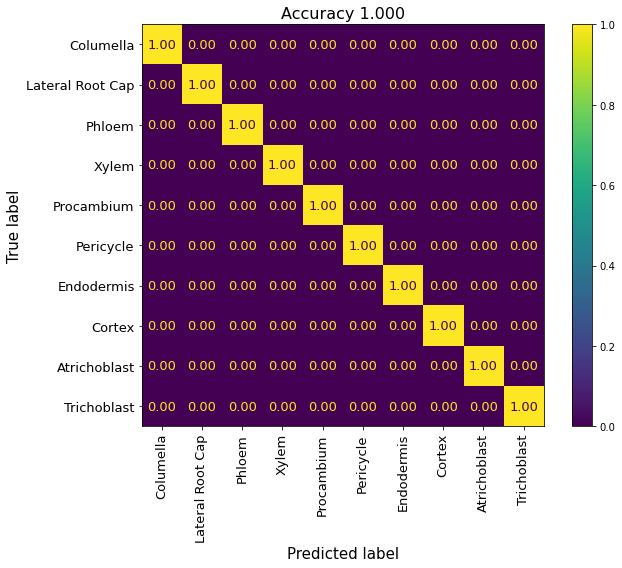

In [30]:
## Evaluate
plot_cfmt(y_pred, y_true, "test_cf_t1.pdf")

In [31]:
test_h = model.init_hidden(batch_size)
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for sample in test_loader:
        test_h = tuple([each.data for each in test_h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        p, test_h = model.predict_proba(x, test_h, 2)
        y_pred.append(p.cpu().detach().numpy())
        y_true.append(y.cpu().detach().numpy())
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)
#if return_names:
#    preds = np.argmax(y_pred, axis=1)
#    predictions = [num2class[i] for i in preds]
#    predicted_label = pd.DataFrame({"cellname":test_gene_mat.index, "predictions":predictions})
#    return predicted_label
#return y_pred

In [32]:
preds = np.argmax(y_pred, axis=1)
predictions = [num2class[i] for i in preds]
trues = [num2class[i] for i in y_true]

In [33]:
y_pred.shape

(22016, 10)

In [34]:
y_true.shape

(22016,)

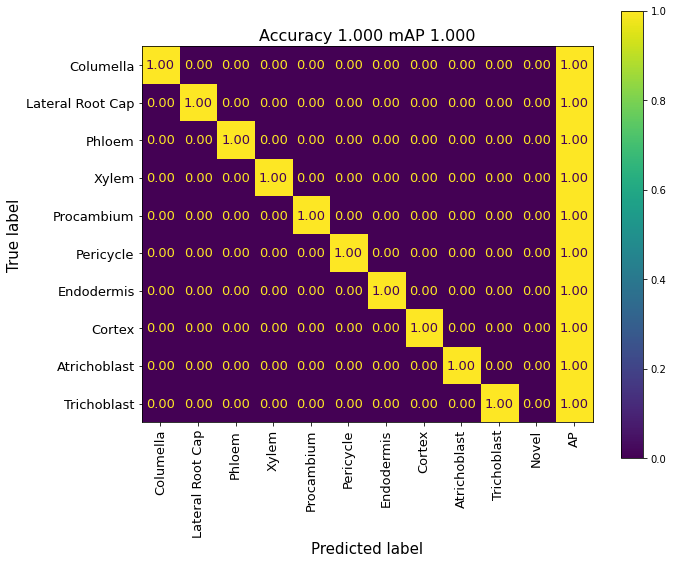

In [35]:
## Evaluate
plot_cfmt(y_pred, y_true, "test_cf_t2.pdf")

In [36]:
test_h = model.init_hidden(batch_size)
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for sample in test_loader:
        test_h = tuple([each.data for each in test_h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        p, test_h = model.predict_proba(x, test_h, 3)
        y_pred.append(p.cpu().detach().numpy())
        y_true.append(y.cpu().detach().numpy())
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)
#if return_names:
#    preds = np.argmax(y_pred, axis=1)
#    predictions = [num2class[i] for i in preds]
#    predicted_label = pd.DataFrame({"cellname":test_gene_mat.index, "predictions":predictions})
#    return predicted_label
#return y_pred

In [37]:
preds = np.argmax(y_pred, axis=1)
predictions = [num2class[i] for i in preds]
trues = [num2class[i] for i in y_true]

In [38]:
y_pred.shape

(22016, 10)

In [39]:
y_true.shape

(22016,)

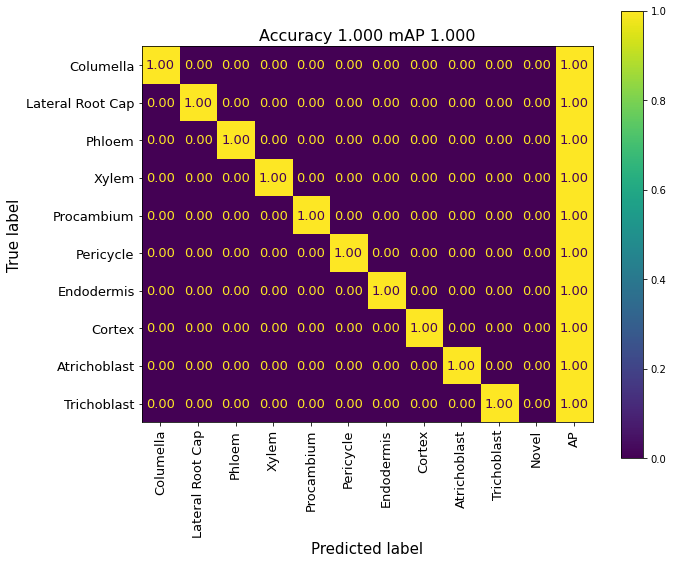

In [40]:
## Evaluate
plot_cfmt(y_pred, y_true, "test_cf_t3.pdf")

## Sample from atlas

In [26]:
X_all = np.vstack((data['X_train'],data['X_val'],data['X_test']))

In [27]:
X_all.shape

(110427, 17513)

In [28]:
y_all = pd.concat((data['y_train'],data['y_val'],data['y_test']))

In [29]:
y_all

ATCCGTCTCACCTCGT_5     6_7.0
GACATCAAGCGAACTG_9     7_6.0
CATTCTACAGAGTCAG_3     4_2.0
AGCAGCCGTGCAGGTA_14    5_3.0
TATATCCCAGGCAATG_5     3_5.0
                       ...  
CGATGGCCAGCTGAAG_10    1_3.0
CACAGATTCTCCCAAC_1     6_5.0
TGCTGAAAGGTCCTGC_13    7_1.0
CATGCAAGTGGCCTCA_5     6_3.0
ACTGATGAGTACAACA_13    8_5.0
Length: 110427, dtype: object

In [30]:
batch_size = 2000

In [31]:
all_dataset = Root_Dataset(X_all, y_all)
all_loader = DataLoader(all_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [32]:
sample = next(iter(all_loader))

In [36]:
pred_h = model.init_hidden(batch_size)

In [38]:
x = sample['x'].to(device)

In [39]:
x.shape

torch.Size([2000, 11, 17513])

In [40]:
model.get_belief(x, pred_h)

In [41]:
model.b.shape

torch.Size([2000, 11, 512])

In [42]:
x.shape

torch.Size([2000, 11, 17513])

In [43]:
x[:,0,:].shape

torch.Size([2000, 17513])

In [44]:
x[:,0,:]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1141, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0828, 0.0039],
        [0.0000, 0.0000, 0.0000,  ..., 0.0703, 0.0070, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0465, 0.0636, 0.0324],
        [0.0000, 0.0000, 0.0000,  ..., 0.0272, 0.0312, 0.0000],
        [0.0000, 0.0000, 0.0140,  ..., 0.0000, 0.0000, 0.0000]])

## Compare similarity among dev stages in GeneSys

In [55]:
model.eval()
sample0 = next(iter(all_loader))
x_all = sample0['x'].to(device)
#y_all = sample0['y'].to(device)
with torch.no_grad():
    for sample in all_loader:
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        x_all = np.vstack((x_all, x))
        #y_all = pd.concat(pd.Series(y_all),pd.Series(y))


In [58]:
x = x_all[2000:,:,:]

In [61]:
x.shape

(110000, 11, 17513)

In [33]:
x.shape

torch.Size([2000, 11, 17513])

In [44]:
np.vstack((x,x1)).shape

(4000, 11, 17513)

In [49]:
pd.concat((pd.Series(y),pd.Series(y1))).shape

(4000,)

In [34]:
pd.Series(y).value_counts()

6    225
8    214
1    211
3    206
9    204
2    196
0    194
5    193
7    185
4    172
dtype: int64

In [62]:
x[:,1,:].shape

(110000, 17513)

In [167]:
Time = ['t01','t12','t23','t34','t45','t56','t67','t78','t89','t910']

Text(0, 0.5, 'Euclidean distance')

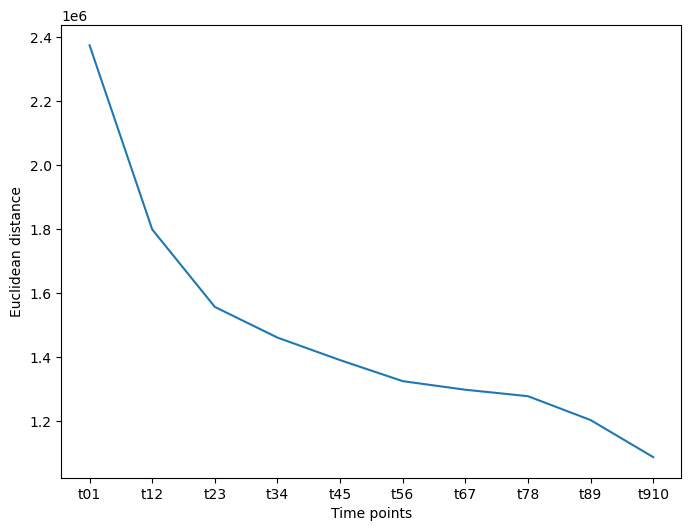

In [170]:
figure(figsize=(8, 6), dpi=100)
#plt.plot(time, test_acc3, label="Training set")
plt.plot(Time, Dis)
plt.xlabel('Time points')
plt.ylabel('Euclidean distance')
#plt.xticks(np.arange(1, 11, 1.0))
#plt.yticks(np.arange(0, 1.1, 0.1))
#plt.legend(loc='lower right')

In [171]:
Dis = []
Dis.append(np.sum(np.sqrt((x[:,0,:]-x[:,1,:])**2).to('cpu').detach().numpy()))
Dis.append(np.sum(np.sqrt((x[:,0,:]-x[:,2,:])**2).to('cpu').detach().numpy()))
Dis.append(np.sum(np.sqrt((x[:,0,:]-x[:,3,:])**2).to('cpu').detach().numpy()))
Dis.append(np.sum(np.sqrt((x[:,0,:]-x[:,4,:])**2).to('cpu').detach().numpy()))
Dis.append(np.sum(np.sqrt((x[:,0,:]-x[:,5,:])**2).to('cpu').detach().numpy()))
Dis.append(np.sum(np.sqrt((x[:,0,:]-x[:,6,:])**2).to('cpu').detach().numpy()))
Dis.append(np.sum(np.sqrt((x[:,0,:]-x[:,7,:])**2).to('cpu').detach().numpy()))
Dis.append(np.sum(np.sqrt((x[:,0,:]-x[:,8,:])**2).to('cpu').detach().numpy()))
Dis.append(np.sum(np.sqrt((x[:,0,:]-x[:,9,:])**2).to('cpu').detach().numpy()))
Dis.append(np.sum(np.sqrt((x[:,0,:]-x[:,10,:])**2).to('cpu').detach().numpy()))

In [172]:
Time = ['t01','t02','t03','t04','t05','t06','t07','t08','t09','t010']

Text(0, 0.5, 'Euclidean distance')

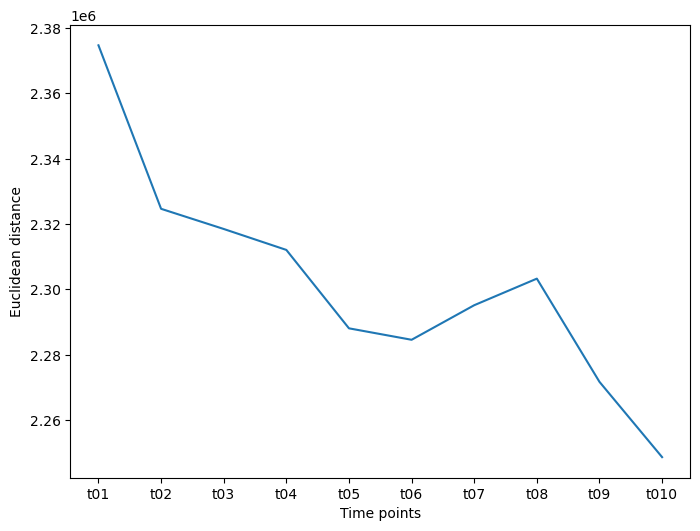

In [173]:
figure(figsize=(8, 6), dpi=100)
#plt.plot(time, test_acc3, label="Training set")
plt.plot(Time, Dis)
plt.xlabel('Time points')
plt.ylabel('Euclidean distance')
#plt.xticks(np.arange(1, 11, 1.0))
#plt.yticks(np.arange(0, 1.1, 0.1))
#plt.legend(loc='lower right')

In [174]:
np.sum(np.sqrt((x[:,0,:]-x[:,1,:])**2).to('cpu').detach().numpy())

0.0

In [65]:
DF_var = pd.DataFrame.from_dict({
    "t0":pd.DataFrame(x[:,0,:]).sum(axis=0).tolist(),
    "t1":pd.DataFrame(x[:,1,:]).sum(axis=0).tolist(),
    "t2":pd.DataFrame(x[:,2,:]).sum(axis=0).tolist(),
    "t3":pd.DataFrame(x[:,3,:]).sum(axis=0).tolist(),
    "t4":pd.DataFrame(x[:,4,:]).sum(axis=0).tolist(),
    "t5":pd.DataFrame(x[:,5,:]).sum(axis=0).tolist(),
    "t6":pd.DataFrame(x[:,6,:]).sum(axis=0).tolist(),
    "t7":pd.DataFrame(x[:,7,:]).sum(axis=0).tolist(),
    "t8":pd.DataFrame(x[:,8,:]).sum(axis=0).tolist(),
    "t9":pd.DataFrame(x[:,9,:]).sum(axis=0).tolist(),
    "t10":pd.DataFrame(x[:,10,:]).sum(axis=0).tolist()
})

In [66]:
DF_var

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10
0,14.732571,4228.057617,12058.116211,12102.027344,11892.773438,11859.666992,11819.847656,10614.248047,7886.677734,8397.487305,5014.310059
1,107.377975,14889.233398,17942.462891,19589.611328,20301.097656,19974.777344,19158.394531,20262.189453,22016.835938,23708.330078,23186.845703
2,797.960022,1510.887695,1866.473511,2040.635986,1823.676758,2041.360474,3331.815918,8114.511230,12585.904297,12694.333984,13276.504883
3,618.885315,28043.919922,29017.121094,27152.822266,25140.347656,23144.615234,20471.484375,19731.931641,19883.250000,21060.394531,19897.541016
4,433.351501,6081.342285,16294.727539,17036.583984,16394.781250,15565.513672,14377.967773,12395.154297,9621.315430,10038.130859,8972.291016
...,...,...,...,...,...,...,...,...,...,...,...
17508,2331.982422,1988.785400,2182.500732,2373.097412,2516.854980,2696.377686,2813.478760,3080.088379,3309.365479,3330.304688,3883.683105
17509,624.455994,1180.653809,1896.357788,2353.770508,2449.844482,2548.883789,2529.960938,2898.588135,3252.120850,3714.583496,4575.627441
17510,1735.169189,1965.684448,2413.213623,2487.619141,2651.990234,2941.145264,2848.513916,3255.869385,3368.055664,3362.947754,3428.333740
17511,3922.373535,1428.486938,1835.647461,2486.775879,2816.149658,3085.135986,3049.563477,3279.297607,3278.488525,3500.128418,3952.376465


In [82]:
all_dataset['x']

{'x': array([[0.        , 0.        , 0.        , ..., 0.07033579, 0.0070321 ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.01445612, 0.        ,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.        , 0.09687226,
         0.00196781],
        ...,
        [0.4203734 , 0.        , 1.        , ..., 0.0771191 , 0.08460439,
         0.04401766],
        [0.34091958, 0.        , 1.        , ..., 0.1184848 , 0.06620395,
         0.06853849],
        [1.        , 0.        , 1.        , ..., 0.05692969, 0.        ,
         0.03121759]], dtype=float32),
 'y': 6}

In [ ]:
import seaborn as sns
from scipy.spatial.distance import pdist,squareform

In [ ]:
df_sqeuc = squareform(pdist(DF_var.T, metric='sqeuclidean'))
dfmax, dfmin = df_sqeuc.max(), df_sqeuc.min()
df_sqeuc = 1 - (df_sqeuc - dfmin)/(dfmax - dfmin)
g = sns.clustermap(df_sqeuc, method='ward')

In [67]:
import seaborn as sns
from scipy.spatial.distance import pdist,squareform

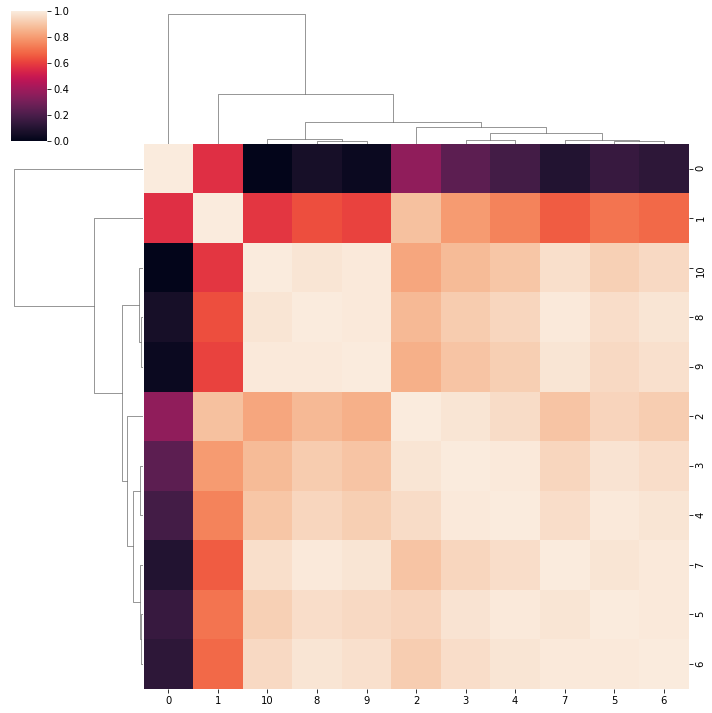

In [68]:
df_sqeuc = squareform(pdist(DF_var.T, metric='sqeuclidean'))
dfmax, dfmin = df_sqeuc.max(), df_sqeuc.min()
df_sqeuc = 1 - (df_sqeuc - dfmin)/(dfmax - dfmin)
g = sns.clustermap(df_sqeuc, method='ward')

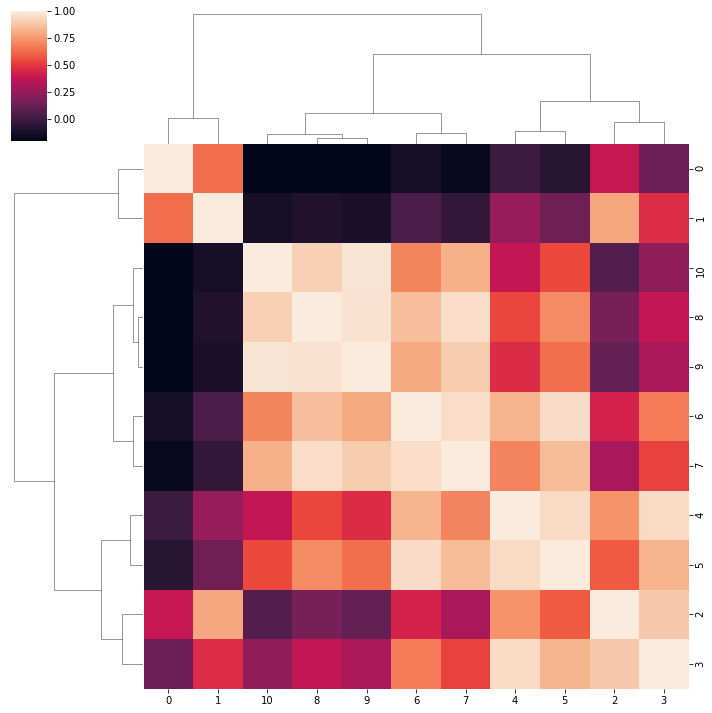

In [69]:
df_cor = 1 - squareform(pdist(DF_var.T, metric='correlation'))
g = sns.clustermap(df_cor, method='ward')

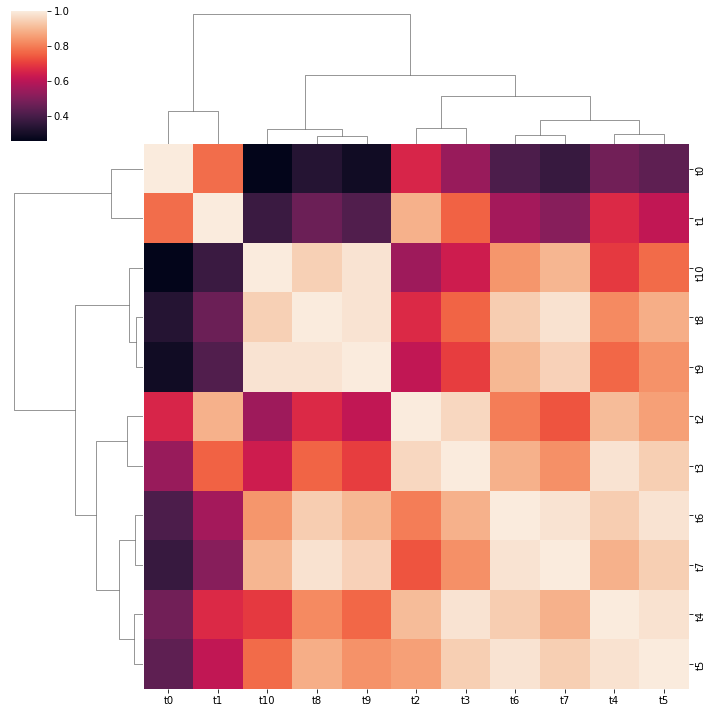

In [70]:
n = np.linalg.norm(DF_var, axis=0).reshape(1, DF_var.shape[1])
cosine_sim = DF_var.T.dot(DF_var) / n.T.dot(n)
g = sns.clustermap(cosine_sim, method='ward')

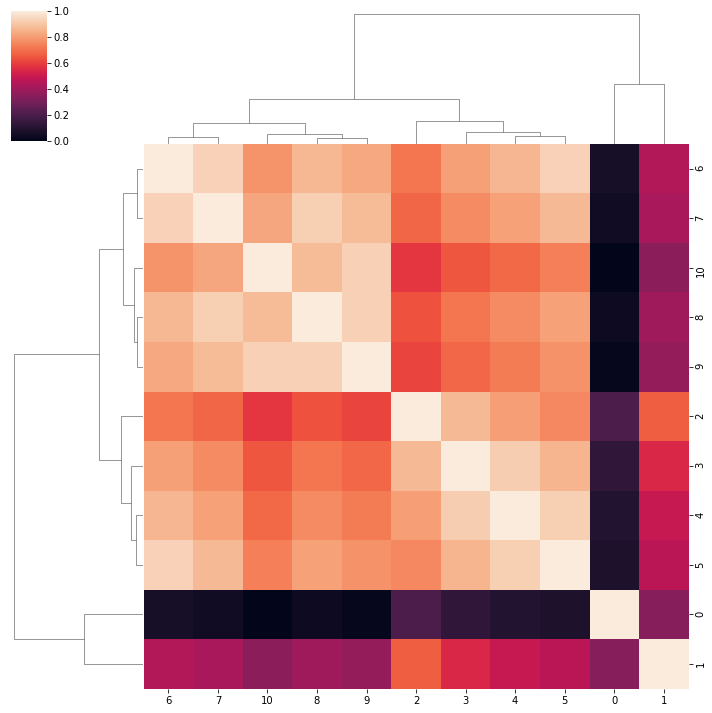

In [71]:
df = squareform(pdist(DF_var.T, metric='euclidean'))
dfmax, dfmin = df.max(), df.min()
df = 1 - (df - dfmin)/(dfmax - dfmin)
g = sns.clustermap(df, method='ward')

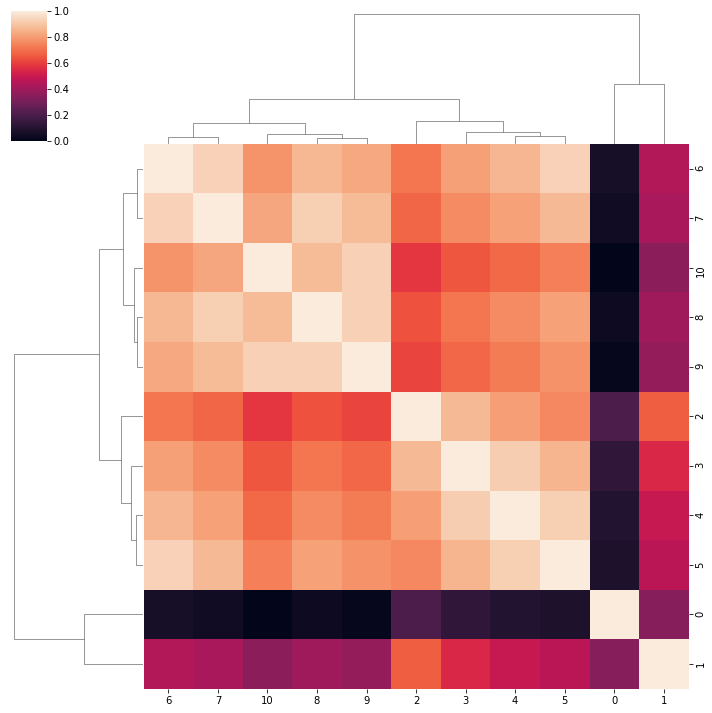

In [72]:
df = squareform(pdist(DF_var.T, metric='minkowski'))
dfmax, dfmin = df.max(), df.min()
df = 1 - (df - dfmin)/(dfmax - dfmin)
g = sns.clustermap(df, method='ward')